In [18]:
# load package
from sklearn import datasets 
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.datasets import fetch_california_housing
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# load data
housing = fetch_california_housing()
Y = pd.DataFrame(data=housing['target'], columns=housing['target_names'])
X = pd.DataFrame(data=housing['data'], columns=housing['feature_names'])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [20]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [21]:
Y

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422
...,...
20635,0.781
20636,0.771
20637,0.923
20638,0.847


In [22]:
# build lightgbm data
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [23]:
# set params
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [24]:
# model train
gbm1 = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=10)

[1]	training's l2: 1.23856	valid_1's l2: 1.2715
Training until validation scores don't improve for 10 rounds.
[2]	training's l2: 1.16057	valid_1's l2: 1.19255
[3]	training's l2: 1.09633	valid_1's l2: 1.12749
[4]	training's l2: 1.03179	valid_1's l2: 1.06198
[5]	training's l2: 0.979685	valid_1's l2: 1.0094
[6]	training's l2: 0.925378	valid_1's l2: 0.953761
[7]	training's l2: 0.876336	valid_1's l2: 0.904049
[8]	training's l2: 0.828646	valid_1's l2: 0.856528
[9]	training's l2: 0.787129	valid_1's l2: 0.814784
[10]	training's l2: 0.74667	valid_1's l2: 0.773438
[11]	training's l2: 0.712037	valid_1's l2: 0.738821
[12]	training's l2: 0.679931	valid_1's l2: 0.706476
[13]	training's l2: 0.651992	valid_1's l2: 0.679253
[14]	training's l2: 0.622372	valid_1's l2: 0.650223
[15]	training's l2: 0.595443	valid_1's l2: 0.623187
[16]	training's l2: 0.570915	valid_1's l2: 0.599406
[17]	training's l2: 0.549103	valid_1's l2: 0.577307
[18]	training's l2: 0.52927	valid_1's l2: 0.55756
[19]	training's l2: 0.510

In [26]:
# custom loss and eval
def custom_mse_loss(y_pred, data):
    y_true = data.get_label()
    error = y_pred-y_true
    
    #1st derivative of loss function
    grad = 2 * error

    #2nd derivative of loss function
    hess = 0 * error + 2
    
    return grad, hess

def custom_mse_eval(y_pred, data):

    y_true = data.get_label()
    error = y_pred-y_true

    return 'l2 loss custom', np.mean(np.square(error)), False

gbm2 = lgb.train(params,
                lgb_train,
                fobj=custom_mse_loss,
                feval=custom_mse_eval,
                num_boost_round=30,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=10)

[1]	training's l2: 5.0927	training's l2 loss custom: 5.0927	valid_1's l2: 5.15175	valid_1's l2 loss custom: 5.15175
Training until validation scores don't improve for 10 rounds.
[2]	training's l2: 4.6387	training's l2 loss custom: 4.6387	valid_1's l2: 4.69574	valid_1's l2 loss custom: 4.69574
[3]	training's l2: 4.23561	training's l2 loss custom: 4.23561	valid_1's l2: 4.29176	valid_1's l2 loss custom: 4.29176
[4]	training's l2: 3.8645	training's l2 loss custom: 3.8645	valid_1's l2: 3.91779	valid_1's l2 loss custom: 3.91779
[5]	training's l2: 3.53621	training's l2 loss custom: 3.53621	valid_1's l2: 3.58798	valid_1's l2 loss custom: 3.58798
[6]	training's l2: 3.23229	training's l2 loss custom: 3.23229	valid_1's l2: 3.28141	valid_1's l2 loss custom: 3.28141
[7]	training's l2: 2.95794	training's l2 loss custom: 2.95794	valid_1's l2: 3.00386	valid_1's l2 loss custom: 3.00386
[8]	training's l2: 2.70724	training's l2 loss custom: 2.70724	valid_1's l2: 2.75177	valid_1's l2 loss custom: 2.75177


In [27]:
## 预测
y_pred1 = gbm1.predict(x_test, num_iteration=gbm1.best_iteration)

## 评估
print('原始lightgbm预测结果指标:')
print('MSE为：', mean_squared_error(y_test,y_pred1))
print('RMSE:', mean_squared_error(y_test, y_pred1) ** 0.5)
print('R^2:', r2_score(y_test, y_pred1))

原始lightgbm预测结果指标:
MSE为： 0.5228308966725237
RMSE: 0.7230704645278521
R^2: 0.6143295059957307


In [28]:
## 预测
y_pred2 = gbm2.predict(x_test, num_iteration=gbm2.best_iteration)
## 评估
print('自定义loss和eval的lightgbm预测结果指标:')
print('MSE为：', mean_squared_error(y_test,y_pred2))
print('RMSE:', mean_squared_error(y_test, y_pred2) ** 0.5)
print('R^2:', r2_score(y_test, y_pred2))


自定义loss和eval的lightgbm预测结果指标:
MSE为： 0.6054379525778563
RMSE: 0.77809893495484
R^2: 0.553393734483354


原始lightgbm特征重要度


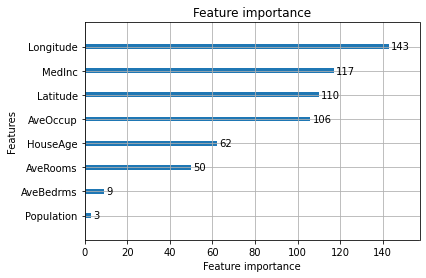

In [29]:
print('原始lightgbm特征重要度')
ax = lgb.plot_importance(gbm1, max_num_features=10)
plt.show()

自定义loss和eval的特征重要度


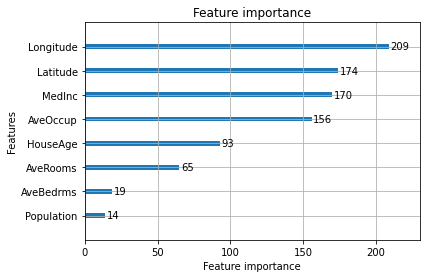

In [30]:
print('自定义loss和eval的特征重要度')
ax = lgb.plot_importance(gbm2, max_num_features=10)
plt.show()

In [39]:
def custom_asymmetric_train(y_pred, data):
    y_true = data.get_label()
    residual = (y_true - y_pred)
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess

def custom_asymmetric_valid(y_pred, data):
    y_true = data.get_label()
    residual = (y_true - y_pred)
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

gbm3 = lgb.train(params,
                lgb_train,
                fobj=custom_asymmetric_train,
                feval=custom_asymmetric_valid,
                num_boost_round=50,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=10)


[1]	training's l2: 5.0927	training's custom_asymmetric_eval: 5.0927	valid_1's l2: 5.15175	valid_1's custom_asymmetric_eval: 5.15175
Training until validation scores don't improve for 10 rounds.
[2]	training's l2: 4.6387	training's custom_asymmetric_eval: 4.6387	valid_1's l2: 4.69574	valid_1's custom_asymmetric_eval: 4.69574
[3]	training's l2: 4.23781	training's custom_asymmetric_eval: 4.23784	valid_1's l2: 4.29351	valid_1's custom_asymmetric_eval: 4.29351
[4]	training's l2: 3.86699	training's custom_asymmetric_eval: 3.86709	valid_1's l2: 3.9201	valid_1's custom_asymmetric_eval: 3.92011
[5]	training's l2: 3.53949	training's custom_asymmetric_eval: 3.53974	valid_1's l2: 3.59231	valid_1's custom_asymmetric_eval: 3.59237
[6]	training's l2: 3.23706	training's custom_asymmetric_eval: 3.2375	valid_1's l2: 3.28778	valid_1's custom_asymmetric_eval: 3.28801
[7]	training's l2: 2.96089	training's custom_asymmetric_eval: 2.96161	valid_1's l2: 3.00913	valid_1's custom_asymmetric_eval: 3.00962
[8]	tr

In [40]:
## 预测
y_pred3 = gbm3.predict(x_test, num_iteration=gbm3.best_iteration)
## 评估
print('自定义loss和eval的lightgbm预测结果指标:')
print('MSE为：', mean_squared_error(y_test,y_pred3))
print('RMSE:', mean_squared_error(y_test, y_pred3) ** 0.5)
print('R^2:', r2_score(y_test, y_pred3))

自定义loss和eval的lightgbm预测结果指标:
MSE为： 0.44908958051848574
RMSE: 0.6701414630646918
R^2: 0.6687253919516943
